In [1]:
from UTILITY_quickstart import *

importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch_baseline.yml")

In [2]:
csrTF = True


bunchCount = importedDefaultSettings["bunchCount"]

tao = initializeTao(
    inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"],
    
    csrTF = csrTF,
    numMacroParticles=1e5,
    scratchPath = "/tmp",
    randomizeFileNames = True
)

setLattice(tao, **importedDefaultSettings)
launchTwissCorrection(tao)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR on
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
Number of macro particles = 100000.0
Beam created, written to /tmp/beams/activeBeamFile_5539084578925383002.h5, and reinit to tao
No evalElement provided. Assuming golden lattice PR10571
Optimization Results:
Optimal Parameters: [28.77865964 13.39705392 23.51276157 16.83077823]
Objective Function Value at Optimal Parameters: 3.875225216013324e-12
Number of Iterations: 354
Converged: True


In [3]:
trackStart = "IM14890"
trackEnd = "PR15944"

trackBeam(tao, trackEnd = trackStart, **importedDefaultSettings)

PStart = getBeamAtElement(tao, trackStart)

makeBeamActiveBeamFile( PStart, tao = tao )



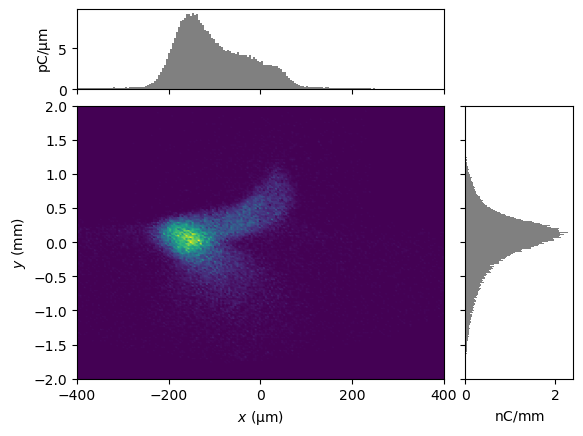

/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:498: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


{'PDrive_median_x': -0.00011674384116303765,
 'PDrive_median_y': 6.515780532043237e-05,
 'PDrive_median_xp': -1.3189774270668864e-05,
 'PDrive_median_yp': -4.874174062804385e-06,
 'PDrive_sigmaSI90_x': 8.602032939212852e-05,
 'PDrive_sigmaSI90_y': 0.0004668864715870993,
 'PDrive_sigmaSI90_z': 3.8103400302462494e-05,
 'PDrive_sigmaSI90_xp': 1.2132289846882557e-05,
 'PDrive_sigmaSI90_yp': 2.9741015550820687e-05,
 'PDrive_emitSI90_x': 8.47687235177468e-06,
 'PDrive_emitSI90_y': 2.4913333521230192e-05,
 'PDrive_norm_emit_x': 5.59688224788519e-06,
 'PDrive_norm_emit_y': 5.0938886053034696e-06,
 'PDrive_charge_nC': 1.5996480000000006}

<Figure size 640x480 with 0 Axes>

In [4]:
tao.cmd(f"set ele TCY15280 VOLTAGE = 20e6")
tao.cmd(f"set ele TCY15280 PHI0 = {0/360.0}")

trackBeam(tao, trackStart = trackStart, trackEnd = trackEnd, **importedDefaultSettings)


P = getBeamAtElement(tao, trackEnd)
display(plotMod(P, 'x', 'y', bins=300, xlim = (-0.4e-3, 0.4e-3), ylim = (-2e-3,2e-3)))
plt.clf()

getBeamSpecs(P)

## Scan

In [10]:
data = []
quadStep = 10
allQuadSettings = np.arange(-60, 0 + quadStep, quadStep)

for quadSetting in allQuadSettings:
    setQuadkG(tao, "Q14901", quadSetting)

    # trackBeam(tao, trackStart = trackStart, trackEnd = trackEnd, **importedDefaultSettings)

    # P = getBeamAtElement(tao, trackEnd)

    # fileName = f"/Users/nmajik/{quadSetting}.png"
    # print(fileName)
    
    # fig = plotMod(P, 'x', 'y', bins=300, xlim = (-0.4e-3, 0.4e-3), ylim = (-2e-3,2e-3))

    # fig.savefig(fileName)


    transferMatrix = getMatrix(tao, trackStart, trackEnd)

    trackBeam(tao, trackStart = trackStart, trackEnd = trackEnd, **importedDefaultSettings)

    P = getBeamAtElement(tao, trackEnd)
    
    #spotSize = smallestIntervalImpliedSigma(P.x)
    spotSize = P["sigma_x"]

    data.append(
        {
            "quadSetting" : quadSetting,
            "R11" : transferMatrix[0][0],
            "R12" : transferMatrix[0][1],
            "sigma" : spotSize,
            "beam" : P
        }
    )

    

In [14]:
P["mean_energy"]

5538390988.332017

In [ ]:
getSingleBeamSlice( P, sortKey = "y", minVal = 0, maxVal = 100e-6 ) 

In [19]:
generalizedEmittanceSolver( data, energyGeV = 4.5 )

{'beta': 5.7318230725801484,
 'alpha': 1.12991370709406,
 'emitGeo': 1.856914179914836e-09,
 'emit': 1.6352473208643367e-05}

In [16]:
PStart.twiss(fraction = 0.95)

{'alpha_x': 0.9012715959336728,
 'beta_x': 4.713669414728765,
 'gamma_x': 0.38447551794234436,
 'emit_x': 7.719707331750953e-10,
 'eta_x': -0.0024820831023868637,
 'etap_x': 0.0003857683428114579,
 'norm_emit_x': 6.6928458707821336e-06}

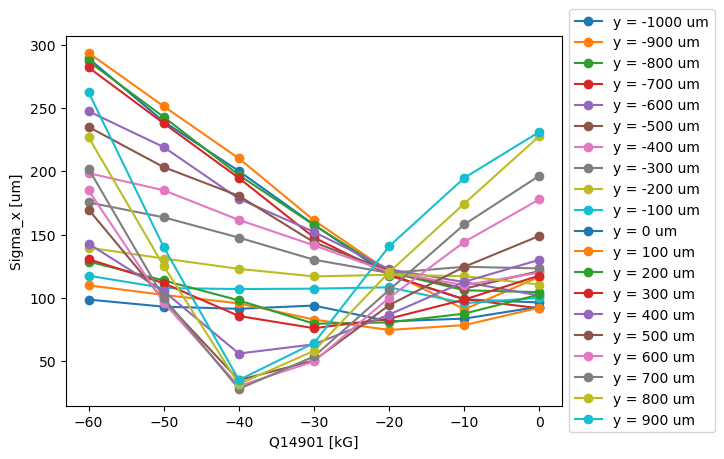

In [42]:
for binStartum in np.arange(-1000, 1000, 100):
    activeSigmaArr = []
    for row in data:
        PTmp = getSingleBeamSlice(row["beam"], sortKey="y", minVal=(binStartum/1e6), maxVal=((binStartum + 100)/1e6))
        activeSigmaArr.append(PTmp["sigma_x"])
    
    plt.plot(allQuadSettings, 1e6 * np.array(activeSigmaArr), marker='o', linestyle='-', label=f'y = {binStartum} um')

plt.xlabel("Q14901 [kG]")
plt.ylabel("Sigma_x [um]")

# Move the legend to the right side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

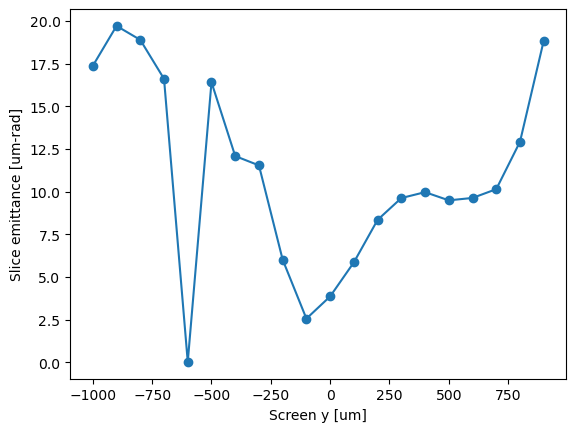

In [46]:
allBinStartum = np.arange(-1000, 1000, 100)
calculatedSliceEmittances = []


for binStartum in allBinStartum:
    activeData = []
    for row in data:
        
        PTmp = getSingleBeamSlice(row["beam"], sortKey="y", minVal=(binStartum/1e6), maxVal=((binStartum + 100)/1e6))
        
        activeData.append(
            {
                "R11" : row["R11"],
                "R12" : row["R12"],
                "sigma" : PTmp["sigma_x"]
            }
        )

    calculatedSliceEmittances.append( generalizedEmittanceSolver( activeData, energyGeV = 4.5 )["emit"] ) 


plt.plot(allBinStartum, 1e6 * np.array(calculatedSliceEmittances), marker='o', linestyle='-')

plt.xlabel("Screen y [um]")
plt.ylabel("Slice emittance [um-rad]")


plt.show()

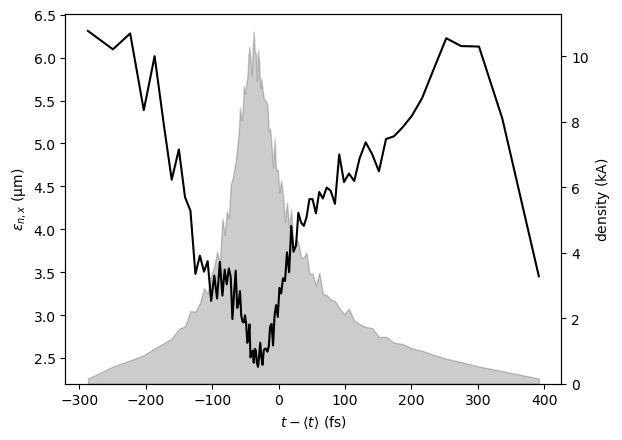

In [50]:
display(slicePlotMod(PStart, 'norm_emit_x', slice_key = "delta_t", n_slice=100))

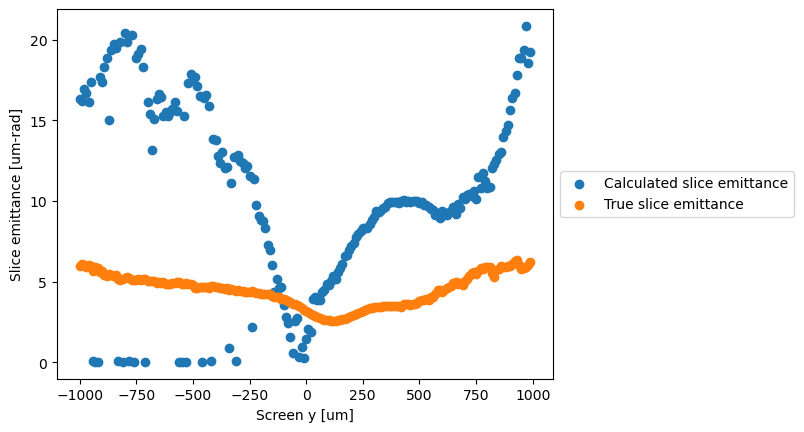

In [72]:
plt.clf() 

ySliceHalfWidth = 50e-6

#Note that some signs are flipped below because this is negative!
resolution = -2.4412906612140807e-10 #seconds/meter

allBinCenters = np.arange(-1e-3, 1e-3, 10e-6)
calculatedSliceEmittances = []
actualSliceEmittances = []

for binCenter in allBinCenters:


    
    activeData = []
    for row in data:
        
        PTmp = getSingleBeamSlice(row["beam"], sortKey="y", minVal=(binCenter - ySliceHalfWidth), maxVal=(binCenter + ySliceHalfWidth))

        #Sanity check by slicing in time
        #PTmp = getSingleBeamSlice(row["beam"], sortKey="delta_t", minVal=(binCenter + ySliceHalfWidth)*resolution, maxVal=(binCenter - ySliceHalfWidth)*resolution)
        
        activeData.append(
            {
                "R11" : row["R11"],
                "R12" : row["R12"],
                "sigma" : PTmp["sigma_x"]
            }
        )

    calculatedSliceEmittances.append( generalizedEmittanceSolver( activeData, energyGeV = 4.5 )["emit"] )   


    
    PTmp = getSingleBeamSlice(PStart, sortKey="delta_t", minVal=(binCenter + ySliceHalfWidth)*resolution, maxVal=(binCenter - ySliceHalfWidth)*resolution)
    
    actualSliceEmittances.append( PTmp.twiss()["norm_emit_x"] )




#plt.scatter(1e6 * np.array(allBinCenters), 1e6 * np.array(calculatedSliceEmittances), marker='o', label = "Calculated slice emittance (magic t slices)")
plt.scatter(1e6 * np.array(allBinCenters), 1e6 * np.array(calculatedSliceEmittances), marker='o', label = "Calculated slice emittance")
plt.scatter(1e6 * np.array(allBinCenters), 1e6 * np.array(actualSliceEmittances), marker='o', label = "True slice emittance" )

plt.xlabel("Screen y [um]")
plt.ylabel("Slice emittance [um-rad]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


